## Setup

In [1]:
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd 
import time
import datetime
import calendar
import networkx as nx

## Reading Observations and Observers

The files used were downloaded from [SILSO's Group Number page](http://www.sidc.be/silso/groupnumberv3).  The current version used is JV_V1-12, but turned into a .csv file.  The original file contains leap years that should not be there, which were removed by hand (1700, 1800, 1900).

### Reading Observations

In [2]:
GN_Dat = pd.read_csv('GNObservations_JV_V1-12.csv', quotechar = '"', encoding = 'ansi',header = 15)

We add two more columns to the data:
    1. ORDINAL:  number of days after (0001,01,01).
    2. FRACYEAR: Fractional year for plotting.

In [3]:
GN_Dat['ORDINAL'] = GN_Dat.apply(lambda x: datetime.date(x['YEAR'],x['MONTH'],x['DAY']).toordinal(),axis=1)
GN_Dat['FRACYEAR'] = GN_Dat.apply(lambda x: x['YEAR']
                                            + (  datetime.date(x['YEAR'],x['MONTH'],x['DAY']).toordinal()
                                               - datetime.date(x['YEAR'],1,1).toordinal() )
                                            / (  datetime.date(x['YEAR']+1,1,1).toordinal()
                                               - datetime.date(x['YEAR'],1,1).toordinal() )
                                  ,axis=1)
print(GN_Dat)

         YEAR  MONTH  DAY  STATION  OBSERVER  GROUPS  ORDINAL     FRACYEAR
0        1610      1    1        0         0      -1   587676  1610.000000
1        1610      1    2        0         0      -1   587677  1610.002740
2        1610      1    3        0         0      -1   587678  1610.005479
3        1610      1    4        0         0      -1   587679  1610.008219
4        1610      1    5        0         0      -1   587680  1610.010959
5        1610      1    6        0         0      -1   587681  1610.013699
6        1610      1    7        0         0      -1   587682  1610.016438
7        1610      1    8        0         0      -1   587683  1610.019178
8        1610      1    9        0         0      -1   587684  1610.021918
9        1610      1   10        0         0      -1   587685  1610.024658
10       1610      1   11        0         0      -1   587686  1610.027397
11       1610      1   12        0         0      -1   587687  1610.030137
12       1610      1   13

### Reading Observers

In [4]:
GN_Obs = pd.read_csv('GNObservers_JV_V1-12.csv', quotechar = '"', encoding = 'ansi')
print(GN_Obs)

     STATION  INITIAL   FINAL  TOT.OBS  \
0          1   1610.0  1613.0      210   
1          2   1611.0  1640.0      882   
2          3   1612.0  1612.0       51   
3          4   1612.0  1612.0       37   
4          5   1612.0  1612.0       20   
5          6   1612.0  1613.0      104   
6          7   1612.0  1612.0       29   
7          8   1613.0  1614.0       51   
8          9   1615.0  1617.0       69   
9         10   1616.0  1616.0       12   
10        11      NaN     NaN        0   
11        12   1618.0  1626.0      185   
12        13   1632.0  1632.0       66   
13        14   1621.0  1625.0       82   
14        15   1621.0  1629.0        4   
15        16   1625.0  1625.0        1   
16        17   1626.0  1629.0      126   
17        18   1631.0  1645.0       80   
18        19   1631.0  1631.0        1   
19        20      NaN     NaN        0   
20        21   1633.0  1635.0        2   
21        22   1794.0  1795.0       91   
22        23   1638.0  1639.0     

## Pre-allocating Variables

We create a variable to store each unique observer.  **NOTE THAT CURRENTLY EACH STATION HAS _ONLY_ ONE OBSERVER SO WE DO ALL OUR LOGICAL OPERATIONS USING THE 'STATION' FIELD**.

We also remove the '0' station which indicates a day without observations.

In [5]:
UnObs = sp.unique(GN_Dat.STATION)
UnObs = UnObs[UnObs>0]

And create empty sparse connectivity matrices that will be used to define the properties of the observation network

In [6]:
#Number of days of overlap
LnkDays = sp.sparse.lil_matrix((UnObs.shape[0], UnObs.shape[0]))

### Day adjacency tolerance

Since the amount of groups visible in the Sun don't change radically from day to day, we specify a window of tolerance in which two observations are considered to be _"simultaneous"_.  First priority is given to observations taken on the same calendar date, then to observations within one day are considered, then within two days, and so on until reaching the size of the tolerance window.  The process is ran simultaneously for prior and following days.

In [79]:
DayTol = 10

### Minimum days of overlap

In order to establish a link between two observers in the network, we require to have minimum amount of days of overlap (considering as overlapping days days within DayTol of each other).

In [80]:
MinOvr = 10

## Creating the adjacency matrix

Now we go through all observers **_(stations)_** executing the following algorithm:

1. Pick an observer _(station)_.
2. Find all observers _(stations)_ that have overlapping observations within DayTol.
3. Go through all overlaping observers _(stations)_ and define the adjacency matrices.

In [81]:
pos = {} #Dictionary with positions for plotting the network
for iObs1 in range(UnObs.shape[0]):

    #---------------------
    # 1. Pick an observer    
    #---------------------
    
    Obs1 = GN_Dat[GN_Dat.STATION == UnObs[iObs1]]
    
    #Update position dictionary of for plotting
    pos.update({iObs1: [ sp.mean(Obs1.FRACYEAR), sp.random.random_sample()]})

    # Create an array of valid date of observations including +/- DayTol
    DatObs1 = Obs1.ORDINAL
    TmpList = DatObs1
    for iDat in range(DayTol):
        TmpList = pd.concat([TmpList,DatObs1 + iDat + 1])
        TmpList = pd.concat([TmpList,DatObs1 - iDat - 1])    
    DatObs1 = sp.unique(TmpList)

    
    #---------------------
    # 2. Find all observers that have overlapping observations within DayTol
    #---------------------
    
    ObsOvrlp = sp.in1d(GN_Dat.ORDINAL, DatObs1)
    ObsOvrlp = sp.unique(GN_Dat.STATION[ObsOvrlp])
    ObsOvrlp = ObsOvrlp[sp.logical_and(ObsOvrlp != 0, ObsOvrlp != UnObs[iObs1])]
    
    
    #---------------------
    # 3. Go through all overlaping observers and define the adjacency matrices.
    #---------------------
    
    for iObsOvrlp in range(ObsOvrlp.shape[0]):
        
        #Determine the overlapping observer
        iObs2 = (UnObs==ObsOvrlp[iObsOvrlp]).nonzero()
        Obs2 = GN_Dat[GN_Dat.STATION == ObsOvrlp[iObsOvrlp]]
        DatObs2 = Obs2.ORDINAL
        
        #Find the dates in common (including days within DayTol)
        DatIntrsct = sp.intersect1d(DatObs1,DatObs2)
        
        #Fill the days of overlap adjacency matrix
        if DatIntrsct.shape[0] >= MinOvr:
            LnkDays[iObs1,iObs2] = DatIntrsct.shape[0]

## Creating and plotting graph network

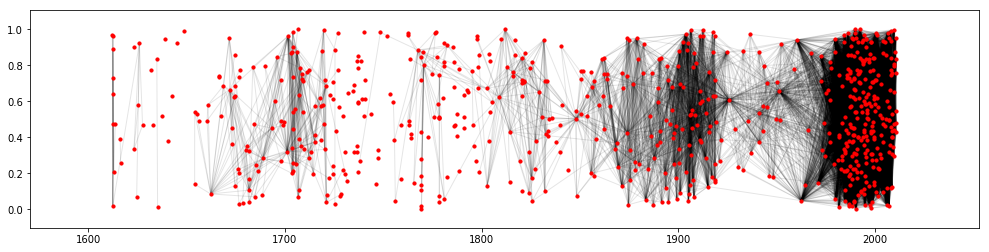

In [82]:
#Creating Graph Network
ObsNtwrk = nx.from_scipy_sparse_matrix(LnkDays,create_using=nx.Graph())

#Clusters existing in the network
Clst = sorted(nx.connected_components(ObsNtwrk), key = len, reverse=True)

#Plotting Graph Network
plt.figure(figsize=(17,4))

#SubNtwrk = ObsNtwrk.subgraph(Clst[1])
SubNtwrk = ObsNtwrk

nx.draw_networkx_nodes(SubNtwrk,pos,node_size=10)
nx.draw_networkx_edges(SubNtwrk,pos,alpha=0.1)
plt.show()

In [83]:
t = sorted(nx.connected_components(ObsNtwrk), key = len, reverse=True)
len(t[1])

99

In [84]:
subNtwrk = ObsNtwrk.subgraph(Clst[1])